In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub

kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

shehapkhalil_cv_data_set_path = kagglehub.dataset_download('shehapkhalil/cv-data-set')
shehapkhalil_yamlfile_path = kagglehub.dataset_download('shehapkhalil/yamlfile')
shehapkhalil_yolo_weight_path = kagglehub.dataset_download('shehapkhalil/yolo-weight')

print('Data source import complete.')


100%|██████████| 74.1M/74.1M [00:03<00:00, 23.3MB/s]

Extracting files...


100%|██████████| 5.31M/5.31M [00:00<00:00, 7.40MB/s]

Extracting files...


100%|██████████| 5.31M/5.31M [00:00<00:00, 7.40MB/s]

Extracting files...
Data source import complete.


In [3]:
!pip install ultralytics
!pip install albumentations
!pip install matplotlib
!pip install tqdm
!pip install Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [4]:
def format_target_to_yolo(boxes, img_size):
    """
    Format the target to YOLO format.
    Handles multiple boxes per image and empty boxes (no objects).

    Args:
        boxes (list): List of bounding boxes in [xmin, ymin, xmax, ymax] format.
        img_size (tuple): Image size (width, height).

    Returns:
        list: List of YOLO format annotations (empty if no objects).
    """
    width, height = img_size
    yolo_annotations = []

    # If no boxes, return empty list (no objects in image)
    if not boxes:
        return yolo_annotations

    for box in boxes:
        # Convert to YOLO format: [label, x_center, y_center, width, height]
        x_center = (box[0] + box[2]) / (2 * width)  # x_center (normalized)
        y_center = (box[1] + box[3]) / (2 * height)  # y_center (normalized)
        box_width = (box[2] - box[0]) / width        # width (normalized)
        box_height = (box[3] - box[1]) / height      # height (normalized)

        # Using class label 1 for objects (change if you have different classes)
        yolo_annotations.append(f"0 {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")

    return yolo_annotations

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

from albumentations.pytorch import ToTensorV2


class LungDataset(Dataset):
    def __init__(self, image_dir, mask_dir, detection_dir, transform=None, task='detection'):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.detection_dir = detection_dir
        self.transform = transform
        self.task = task  # 'detection' or 'segmentation'

        self.data = self._gather_data()

    def _gather_data(self):
        data = []
        subjects = os.listdir(self.image_dir)
        for subject in subjects:
            img_folder = os.path.join(self.image_dir, subject)
            mask_folder = os.path.join(self.mask_dir, subject)
            det_folder = os.path.join(self.detection_dir, subject)

            for img_file in os.listdir(img_folder):
                img_path = os.path.join(img_folder, img_file)
                mask_path = os.path.join(mask_folder, img_file)
                txt_file = img_file.rsplit('.', 1)[0] + '.txt'
                txt_path = os.path.join(det_folder, txt_file)

                boxes = []
                if os.path.exists(txt_path):
                    with open(txt_path, 'r') as f:
                        for line in f:
                            coords = tuple(map(int, line.strip().split(',')))
                            boxes.append(coords)

                data.append({
                    'image': img_path,
                    'mask': mask_path,
                    'boxes': boxes
                })
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        record = self.data[idx]
        image = Image.open(record['image']).convert('RGB')
        image = np.array(image)
        mask = Image.open(record['mask']).convert('L')
        mask = np.array(mask, dtype=np.float32)
        mask[mask == 255.0] = 1.0
        boxes = record['boxes']

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        else:
            image = ToTensorV2()(image)
            mask = ToTensorV2()(mask)

        if self.task == 'detection':
            target = {'boxes': torch.tensor(boxes, dtype=torch.float32)}
            return image, target
        elif self.task == 'segmentation':
            return image, mask

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
# Cell 2: Import libraries
import os
import torch
import numpy as np
import yaml
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO
import shutil

# Cell 4: Prepare YOLO-compatible dataset structure
def prepare_yolo_dataset(dataset, output_dir):
    """
    Prepare YOLOv8 compatible dataset structure from our custom dataset
    Now includes subject name in filenames to handle duplicate image names across subjects
    """
    # Create directory structure
    images_dir = os.path.join(output_dir, 'images')
    labels_dir = os.path.join(output_dir, 'labels')

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    print(len(dataset.data))
    # Process each image and its annotations
    for i in range(len(dataset.data)):
        img_path = dataset.data[i]["image"]
        boxes = dataset.data[i]["boxes"]

        # Get subject name (assuming it's in the path)
        # This extracts the parent directory name as the subject name
        subject_name = os.path.basename(os.path.dirname(img_path))

        # Get image name without path
        img_name = os.path.basename(img_path)
        img_name_no_ext = os.path.splitext(img_name)[0]

        # Create new filename with subject prefix
        new_img_name = f"{subject_name}_{img_name}"
        new_img_name_no_ext = f"{subject_name}_{img_name_no_ext}"

        # Load image to get dimensions
        image = Image.open(img_path)
        width, height = image.size

        # Load and convert annotations
        yolo_annotations = format_target_to_yolo(boxes, (width, height))

        # Copy image to new location with new name
        dest_img_path = os.path.join(images_dir, new_img_name)
        shutil.copy(img_path, dest_img_path)

        # Save YOLO annotations with new name
        label_filename = f"{new_img_name_no_ext}.txt"
        with open(os.path.join(labels_dir, label_filename), 'w') as f:
            for ann in yolo_annotations:
                f.write(f"{ann}\n")

    return output_dir

def create_yolo_data_yaml(train_dir, val_dir, output_path="dataset.yaml"):
    """
    Create a YAML file for YOLOv8 training
    """
    data = {
        'path': os.path.abspath('.'),
        'train': os.path.abspath(os.path.join(train_dir, 'images')),
        'val': os.path.abspath(os.path.join(val_dir, 'images')),
        'names': {0: 'object'},  # Single class as per the dataset
        'nc': 1  # Number of classes
    }

    with open(output_path, 'w') as f:
        yaml.dump(data, f)

    return output_path


# Cell 6: Create datasets
# Create dataset objects
train_dataset = LungDataset(
    image_dir=shehapkhalil_cv_data_set_path+"/train/images",
    mask_dir=shehapkhalil_cv_data_set_path+"/train/masks",
    detection_dir = shehapkhalil_cv_data_set_path+"/train/detections"
)

val_dataset = LungDataset(
    image_dir=shehapkhalil_cv_data_set_path+"/val/images",
    mask_dir=shehapkhalil_cv_data_set_path+"/val/masks",
    detection_dir = shehapkhalil_cv_data_set_path+"/val/detections"
)

# Cell 7: Prepare YOLO-compatible datasets
# Create YOLO format datasets
yolo_train_dir = "yolo_train"
yolo_val_dir = "yolo_val"

print("Preparing training dataset...")
prepare_yolo_dataset(train_dataset, yolo_train_dir)
print("Preparing validation dataset...")
prepare_yolo_dataset(val_dataset, yolo_val_dir)

# Create YAML config file
yaml_path = create_yolo_data_yaml(yolo_train_dir, yolo_val_dir)
print(f"Created YAML config at: {yaml_path}")

# Cell 8: Initialize YOLOv8 model
# Initialize YOLOv8 model without pretrained weights
#model = YOLO('yolov8n.yaml')  # Create a new model from scratch



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Preparing training dataset...
1832
Preparing validation dataset...
98
Created YAML config at: dataset.yaml


In [9]:
def load_or_create_model(model_path=None, config_path=None):
    """Load existing model or create new one"""
    try:
        model = YOLO(model_path)
        print(f"Loaded existing model from {model_path}")
        return model
    except:
        print(f"Creating new model{' from ' + config_path if config_path else ''}")
        model = YOLO(config_path if config_path else 'yolov8n.yaml')
        model.save(model_path)
        return model

In [11]:
## Usage

yolo_model = load_or_create_model(
    model_path = '/content/best_small_object_detector.pt'
)
# yolo_model = YOLO(shehapkhalil_yamlfile_path+'/yolo.yaml')


Loaded existing model from /content/best_small_object_detector.pt


In [12]:
# Try these modifications in your model.train() call:
results = yolo_model.train(
    resume=True,
    data=yaml_path,
    epochs=150,  # Increased from 100
    imgsz=640,   # Slightly larger than 600 (standard YOLO size)
    batch=16 if torch.cuda.is_available() else 4,  # Smaller batch for better gradient estimates

    # Enhanced optimizer settings
    optimizer='AdamW',
    lr0=0.01,   # Higher initial LR with better scheduling
    lrf=0.005,   # More gradual reduction
    warmup_epochs=5.0,

    # Adjusted loss weights for small objects
    box=8.0,     # Reduced from 7.5
    cls=.9,     # Increased from 0.5
    dfl=1.2,     # Slightly reduced

    # Enhanced augmentation
    hsv_h=0.01,  # Reduced hue variation
    hsv_s=0.5,   # Reduced saturation variation
    hsv_v=0.3,   # Reduced value variation
    translate=0.1,  # Reduced translation
    mosaic=0.8,  # Slightly reduced mosaic probability
    mixup=0.05,  # Reduced mixup
    copy_paste=0.05,  # Reduced copy-paste

    # Small object specific
    multi_scale=True,  # Try without multi-scale
    degrees=1.0,  # Reduced rotation
    perspective=0.0,  # No perspective change
    overlap_mask=True,

    # Additional parameters
    dropout=0.1,  # Add dropout for regularization
    patience=20,  # Longer patience
)

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/best_small_object_detector.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0

100%|██████████| 755k/755k [00:00<00:00, 39.3MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

YOLOv8n summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 70/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 162MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1423.2±550.5 MB/s, size: 38.2 KB)


train: Scanning /content/yolo_train/labels... 1832 images, 285 backgrounds, 0 corrupt: 100%|██████████| 1832/1832 [00:00<00:00, 2160.80it/s]


train: New cache created: /content/yolo_train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 553.3±284.4 MB/s, size: 33.0 KB)


val: Scanning /content/yolo_val/labels... 98 images, 20 backgrounds, 0 corrupt: 100%|██████████| 98/98 [00:00<00:00, 1721.06it/s]

val: New cache created: /content/yolo_val/labels.cache


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


AssertionError: /content/best_small_object_detector.pt training to 50 epochs is finished, nothing to resume.
Start a new training without resuming, i.e. 'yolo train model=/content/best_small_object_detector.pt'

In [13]:
val_results = yolo_model.val(data=yaml_path)

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1057.1±639.2 MB/s, size: 33.4 KB)


val: Scanning /content/yolo_val/labels.cache... 98 images, 20 backgrounds, 0 corrupt: 100%|██████████| 98/98 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]


                   all         98         86      0.849      0.384      0.445      0.211
Speed: 0.5ms preprocess, 8.3ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to runs/detect/val


In [ ]:
# Cell 11: Save the trained model
# Save the trained model
yolo_model.save('best_small_object_detector.pt')



image 1/1 /content/yolo_val/images/Subject_58_285.png: 640x640 1 object, 10.6ms
Speed: 8.8ms preprocess, 10.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/yolo_val/images/Subject_58_293.png: 640x640 1 object, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/yolo_val/images/Subject_57_218.png: 640x640 2 objects, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/yolo_val/images/Subject_57_212.png: 640x640 1 object, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/yolo_val/images/Subject_58_297.png: 640x640 (no detections), 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/yolo_val/images/Subject_58_273.png: 640x640 (no detections), 7.4ms
Speed: 2.6ms preprocess

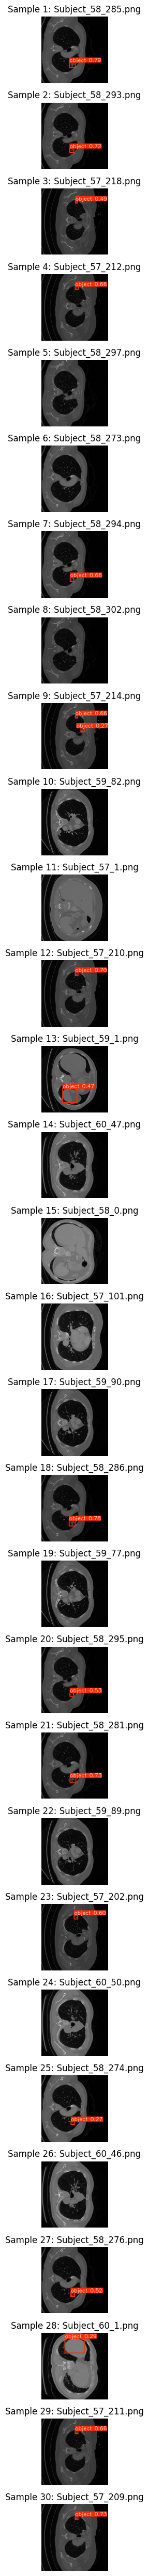

In [14]:
def test_detection(model, dataset_dir, num_samples=30):
    """
    Test detection on some validation images and visualize results
    """

    import random

    images_dir = os.path.join(dataset_dir, 'images')
    all_image_files = os.listdir(images_dir)

    # Randomly select num_samples without replacement
    image_files = random.sample(all_image_files, min(num_samples, len(all_image_files)))

    plt.figure(figsize=(30, 50))

    for i, img_file in enumerate(image_files):
        img_path = os.path.join(images_dir, img_file)

        # Run detection
        results = model(img_path)
        result_img = results[0].plot()

        plt.subplot(num_samples, 1, i+1)
        plt.imshow(result_img)
        plt.title(f"Sample {i+1}: {img_file}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('detection_results.png')
    plt.show()  # Show the plot in Colab

# Test detection on some validation images
test_detection(yolo_model, yolo_val_dir)

In [ ]:
from ultralytics.utils.plotting import plot_results
import pandas as pd

# Load results.csv
results = pd.read_csv('/content/small_object_detection/run23343/results.csv')

# Plot training metrics
plot_results(file='/content/small_object_detection/run23343/results.csv')  # Saves plot to results.png

FileNotFoundError: [Errno 2] No such file or directory: '/content/small_object_detection/run23343/results.csv'

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1195.5±461.4 MB/s, size: 35.0 KB)


val: Scanning /kaggle/working/yolo_val/labels.cache... 98 images, 20 backgrounds, 0 corrupt: 100%|██████████| 98/98 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.1GB RAM): 100%|██████████| 98/98 [00:00<00:00, 487.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.36it/s]


                   all         98         86      0.872      0.634       0.72      0.359
Speed: 2.8ms preprocess, 11.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Saving small_object_detection/run233453/predictions.json...
Results saved to small_object_detection/run233453
confusion matrix
[[         56          11]
 [         30           0]]
{'metrics/precision(B)': np.float64(0.872052095395333), 'metrics/recall(B)': np.float64(0.6340632043810622), 'metrics/mAP50(B)': np.float64(0.7198254889580777), 'metrics/mAP50-95(B)': np.float64(0.35909125586707835), 'fitness': np.float64(0.3951646791761783)}
map50 = 0.7198254889580777
map75 = 0.3373108829120932


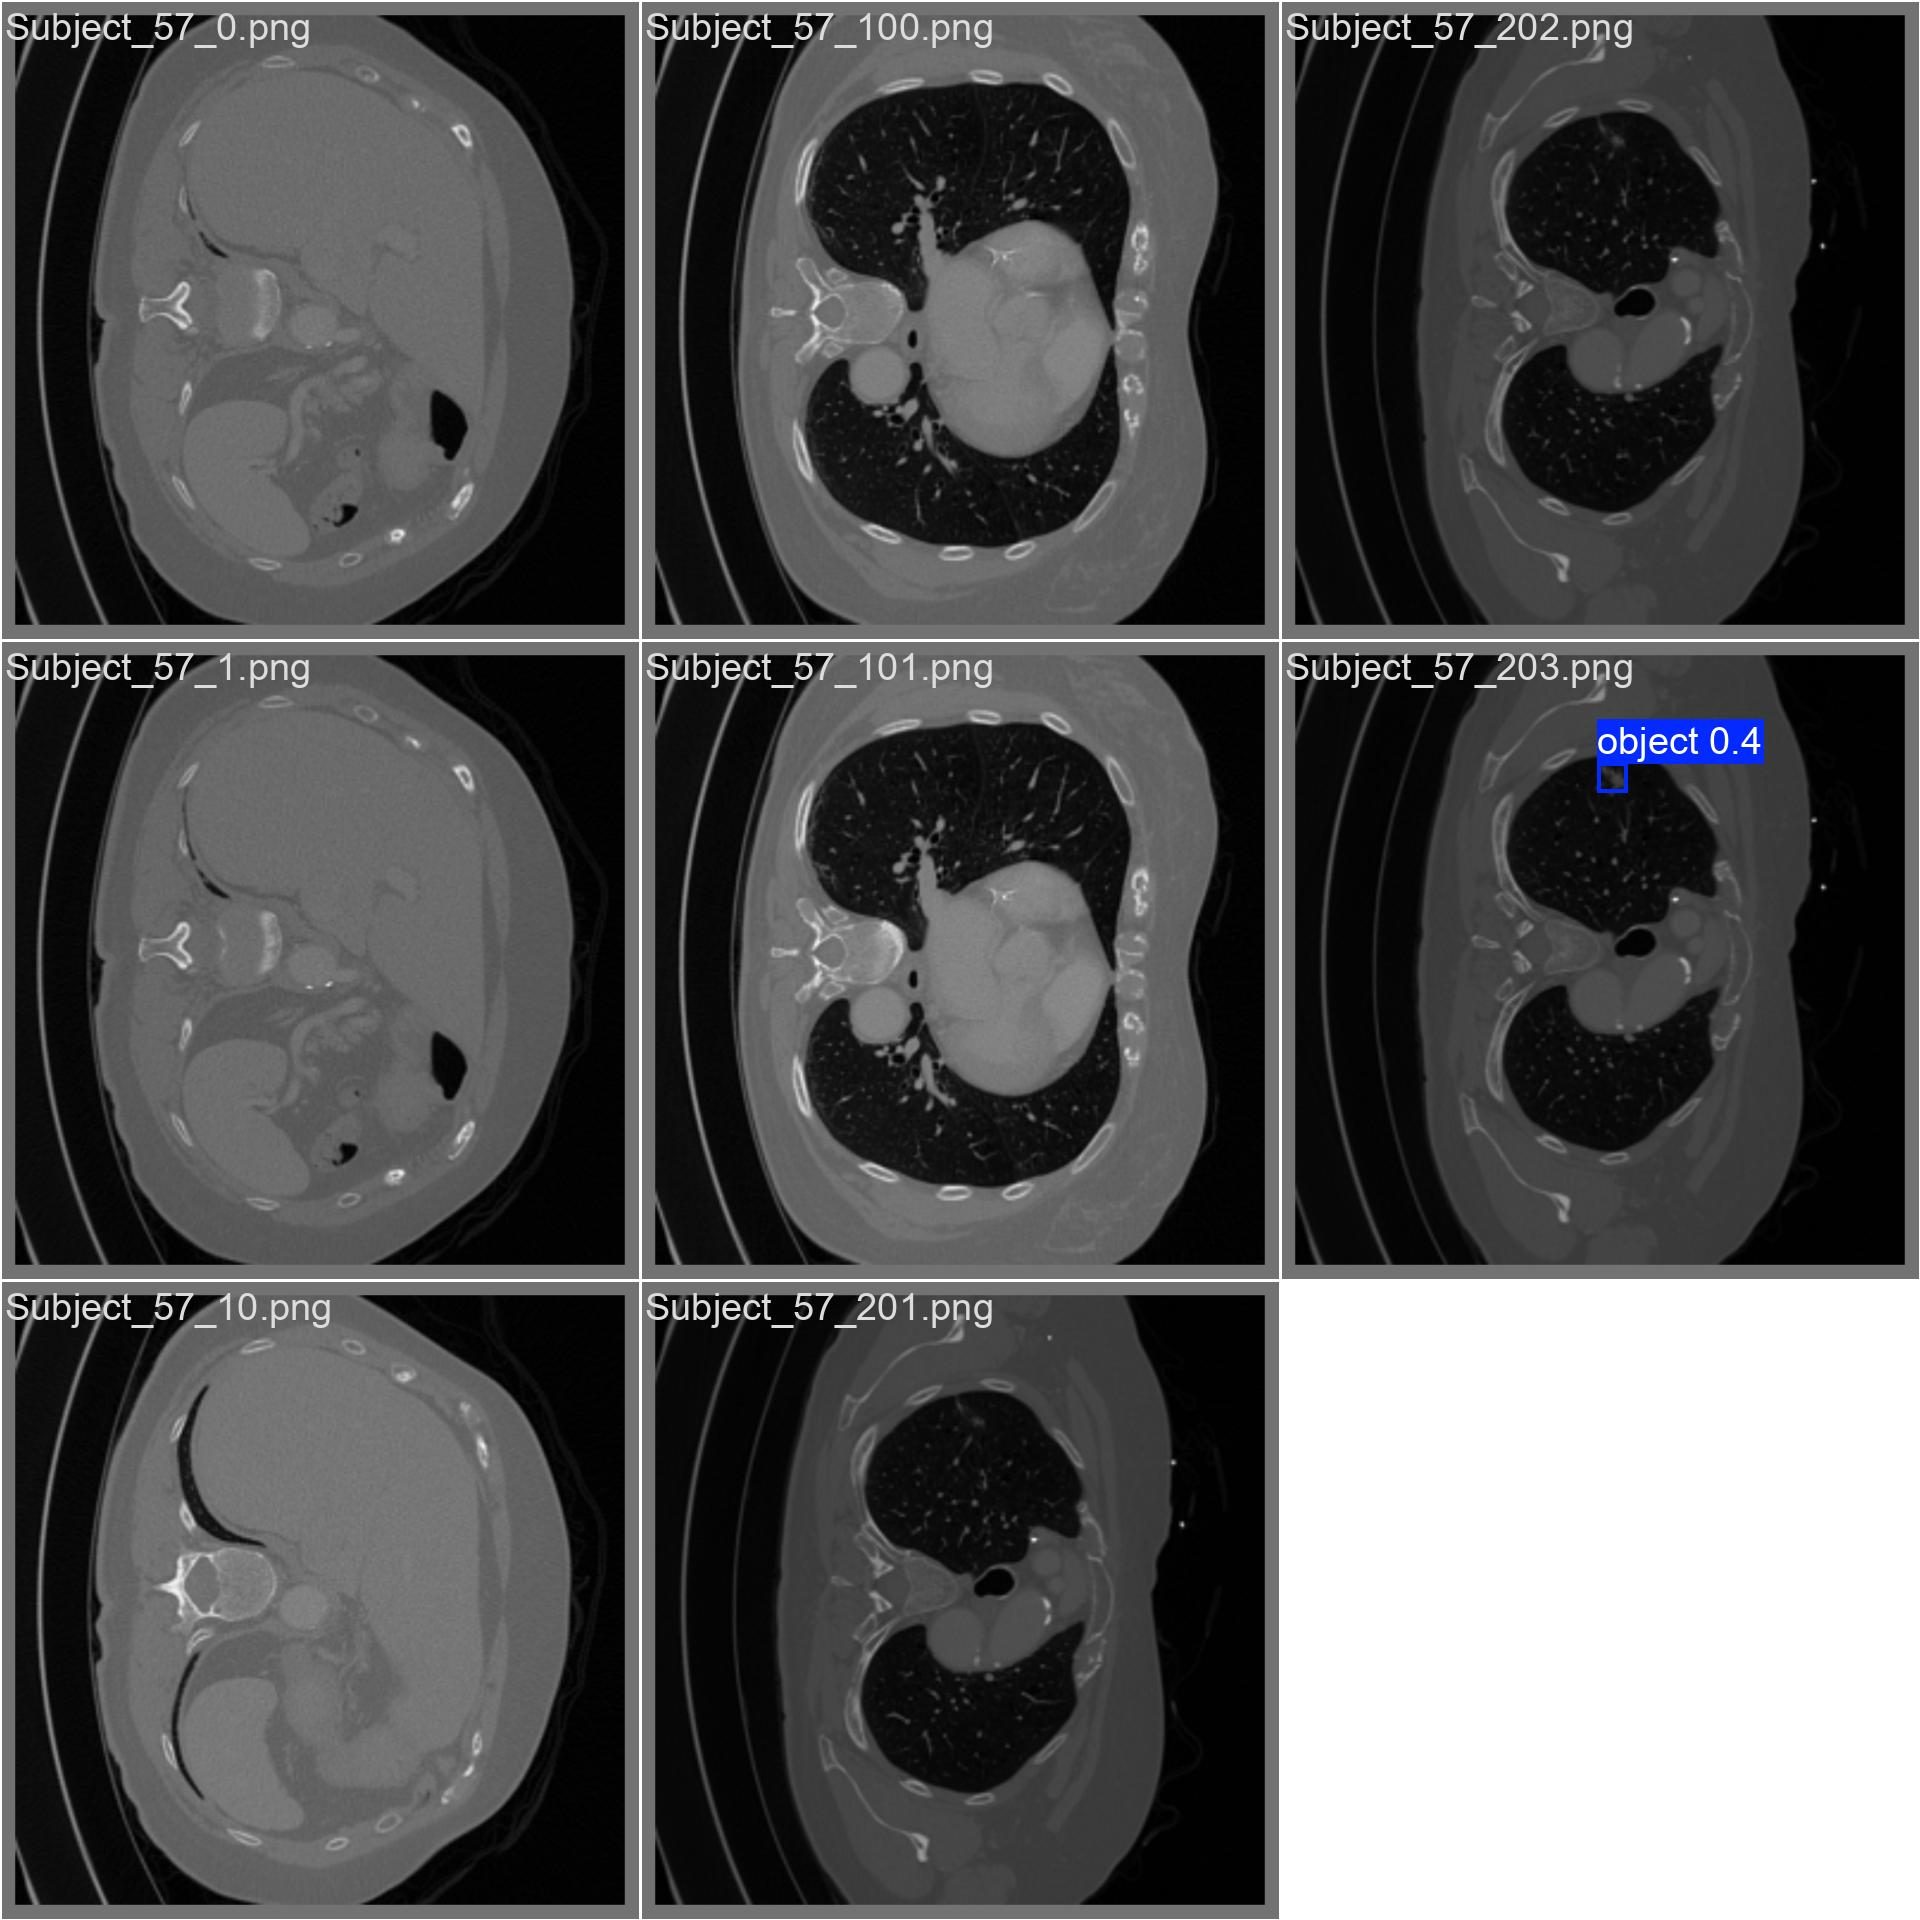

FileNotFoundError: [Errno 2] No such file or directory: '/content/small_object_detection/run23343/results.png'

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Load your trained model


# 1. Save the plots automatically during validation
validation_results = model.val(save_json=True, save_hybrid=True)
print("confusion matrix")
print(validation_results.confusion_matrix.matrix)
print(validation_results.results_dict)
print(f"map50 = {validation_results.box.map50}")
print(f"map75 = {validation_results.box.map75}")
# 2. Display saved plots
results_dir = '/content/small_object_detection/run23343'
display(Image(filename=f'{results_dir}/val_batch0_pred.jpg'))  # Sample predictions
display(Image(filename=f'{results_dir}/results.png'))  # Training curves
display(Image(filename=f'{results_dir}/confusion_matrix.png'))  # Confusion matrix


image 1/1 /root/.cache/kagglehub/datasets/shehapkhalil/cv-data-set/versions/1/val/images/Subject_58/280.png: 640x640 1 object, 17.4ms
Speed: 4.3ms preprocess, 17.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


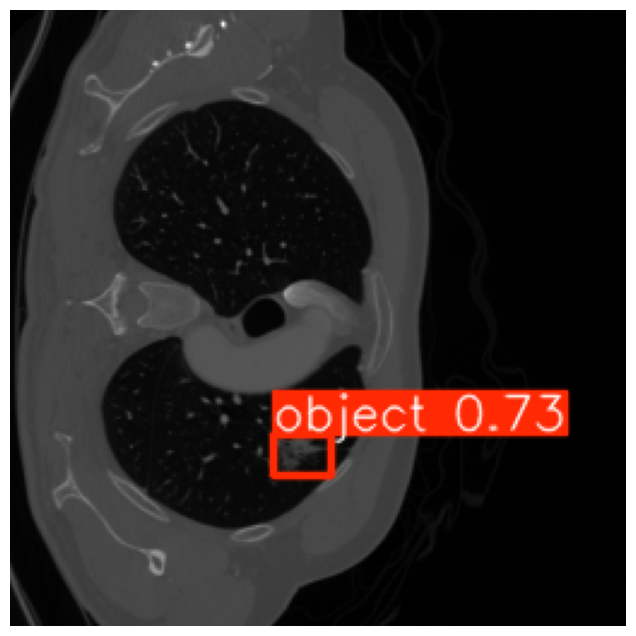

In [15]:

def predict_on_image(model, image_path):
    """
    Run prediction on a single image
    """
    # Run prediction
    results = model(image_path)

    # Plot results
    result_img = results[0].plot()

    # Display results
    plt.figure(figsize=(10, 8))
    plt.imshow(result_img)
    plt.axis('off')
    plt.show()

# Example usage (uncomment to use):
predict_on_image(yolo_model, shehapkhalil_cv_data_set_path+"/val/images/Subject_58/280.png")

# add pipeline

In [16]:
import cv2
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn as nn

In [17]:
def get_deeplabv3_model(num_classes=1):
    # Initialize model with pretrained weights
    model = deeplabv3_resnet50(pretrained=True)

    # Modify the classifier for binary segmentation (foreground/background)
    model.classifier[4] = nn.Conv2d(
        in_channels=256,
        out_channels=num_classes,
        kernel_size=1,
        stride=1
    )

    return model

In [18]:
def segment_with_boxes(model, image_path, bbox_path, device, transform, gt_mask_path=None):
    """
    Performs segmentation on cropped regions defined by bounding boxes in format: x1,y1,x2,y2
    and places the segmentation results back onto the original image. Optionally compares with ground truth.

    Args:
        model: Trained segmentation model
        image_path: Path to the input image
        bbox_path: Path to the bounding box file (format: x1,y1,x2,y2 per line)
        device: Device to run inference on
        transform: Image transformations
        gt_mask_path: Path to ground truth segmentation mask image (optional)

    Returns:
        Dictionary containing:
        - 'original': Original image
        - 'pred_mask': Predicted segmentation mask
        - 'pred_overlay': Prediction overlaid on original image
        - 'gt_mask': Ground truth mask (if provided)
        - 'gt_overlay': Ground truth overlaid on original image (if provided)
        - 'comparison_overlay': Both masks overlaid on original image (if GT provided)
    """
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = image.shape[:2]

    # Create empty mask for the full image
    full_mask = np.zeros((orig_h, orig_w), dtype=np.float32)

    # Load ground truth mask if provided
    gt_mask = None
    if gt_mask_path is not None:
        try:
            gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
            if gt_mask is not None:
                # Resize ground truth mask to match original image if needed
                if gt_mask.shape != (orig_h, orig_w):
                    gt_mask = cv2.resize(gt_mask, (orig_w, orig_h))
                # Normalize to 0-1
                gt_mask = (gt_mask > 128).astype(np.float32)
            else:
                print(f"Warning: Could not load ground truth mask: {gt_mask_path}")
        except Exception as e:
            print(f"Error loading ground truth mask: {e}")
            gt_mask = None

    # Read bounding boxes in x1,y1,x2,y2 format
    boxes = []

    try:
        with open(bbox_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split(',')
            if len(parts) >= 4:  # Format: x1,y1,x2,y2
                try:
                    x1, y1, x2, y2 = map(float, parts[:4])
                    # Convert to integers
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    boxes.append([x1, y1, x2, y2])
                except ValueError:
                    print(f"Warning: Could not parse line: {line.strip()}")
                    continue

    except FileNotFoundError:
        print(f"Bounding box file not found: {bbox_path}")
        results = {
            'original': image,
            'pred_mask': full_mask,
            'pred_overlay': image.copy()
        }
        if gt_mask is not None:
            results['gt_mask'] = gt_mask
            results['gt_overlay'] = image.copy()
            results['comparison_overlay'] = image.copy()
        return results
    except Exception as e:
        print(f"Failed to parse bounding box file: {bbox_path}, Error: {e}")
        results = {
            'original': image,
            'pred_mask': full_mask,
            'pred_overlay': image.copy()
        }
        if gt_mask is not None:
            results['gt_mask'] = gt_mask
            results['gt_overlay'] = image.copy()
            results['comparison_overlay'] = image.copy()
        return results

    model.eval()

    # If no boxes found, return the original image
    if not boxes:
        print(f"No valid bounding boxes found in {bbox_path}")
        results = {
            'original': image,
            'pred_mask': full_mask,
            'pred_overlay': image.copy()
        }
        if gt_mask is not None:
            results['gt_mask'] = gt_mask
            results['gt_overlay'] = image.copy()
            results['comparison_overlay'] = image.copy()
        return results

    # Process each bounding box
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box

        # Ensure coordinates are within image bounds
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(orig_w, x2), min(orig_h, y2)

        # Skip if box is too small or invalid
        if x2 <= x1 or y2 <= y1 or (x2 - x1) < 10 or (y2 - y1) < 10:
            print(f"Warning: Skipping box {i+1} - invalid or too small ({x2-x1}x{y2-y1})")
            continue

        print(f"Processing box {i+1}: ({x1},{y1}) to ({x2},{y2}) - size: {x2-x1}x{y2-y1}")

        # Crop image - ensure we get the exact region
        cropped_image = image[y1:y2, x1:x2].copy()

        if cropped_image.size == 0:
            print(f"Warning: Empty crop for box {i+1}")
            continue

        # Apply transformations
        try:
            augmented = transform(image=cropped_image)
            cropped_tensor = augmented['image'].float().unsqueeze(0).to(device)
        except Exception as e:
            print(f"Warning: Transform failed for box {i+1}: {e}")
            continue

        # Get prediction
        with torch.no_grad():
            output = model(cropped_tensor)['out']
            pred_mask = torch.sigmoid(output) > 0.5
            pred_mask = pred_mask.squeeze().cpu().numpy().astype(np.float32)

        # Get the actual dimensions of the cropped region
        crop_h, crop_w = y2 - y1, x2 - x1

        # Resize mask back to exact crop size using proper interpolation
        if pred_mask.shape != (crop_h, crop_w):
            pred_mask_resized = cv2.resize(pred_mask, (crop_w, crop_h), interpolation=cv2.INTER_NEAREST)
        else:
            pred_mask_resized = pred_mask

        # Ensure the resized mask fits exactly in the crop region
        pred_mask_resized = pred_mask_resized.astype(np.float32)

        # Place the mask in the full image - use maximum to handle overlapping regions
        full_mask[y1:y2, x1:x2] = np.maximum(full_mask[y1:y2, x1:x2], pred_mask_resized)

    # Create overlays
    # Prediction overlay (red)
    pred_colored_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
    pred_colored_mask[full_mask == 1] = [255, 0, 0]  # Red overlay for predictions
    pred_overlay = cv2.addWeighted(image, 1, pred_colored_mask, 0.5, 0)

    # Prepare results dictionary
    results = {
        'original': image,
        'pred_mask': full_mask,
        'pred_overlay': pred_overlay
    }

    # If ground truth is available, create additional overlays
    if gt_mask is not None:
        # Ground truth overlay (green)
        gt_colored_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
        gt_colored_mask[gt_mask == 1] = [0, 255, 0]  # Green overlay for ground truth
        gt_overlay = cv2.addWeighted(image, 1, gt_colored_mask, 0.5, 0)

        # Comparison overlay (GT in green, Pred in red, overlap in yellow)
        comparison_colored_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
        comparison_colored_mask[gt_mask == 1] = [0, 255, 0]  # Green for ground truth

        # Add red for predictions (cast to int32 to avoid overflow, then clip)
        red_mask = np.zeros_like(comparison_colored_mask, dtype=np.int32)
        red_mask[full_mask == 1] = [255, 0, 0]
        comparison_colored_mask = comparison_colored_mask.astype(np.int32) + red_mask
        comparison_colored_mask = np.clip(comparison_colored_mask, 0, 255).astype(np.uint8)
        # Where both are present, it will be yellow (green + red)
        comparison_overlay = cv2.addWeighted(image, 1, comparison_colored_mask, 0.4, 0)

        results.update({
            'gt_mask': gt_mask,
            'gt_overlay': gt_overlay,
            'comparison_overlay': comparison_overlay
        })

    return results


def debug_segmentation_crops(model, image_path, bbox_path, device, transform, gt_mask_path=None):
    """
    Debug version that shows individual crops and their predictions.
    Fixed to handle shape mismatches between predicted masks and cropped images.
    """
    import matplotlib.pyplot as plt

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = image.shape[:2]

    # Read bounding boxes in x1,y1,x2,y2 format
    boxes = []
    try:
        with open(bbox_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split(',')
            if len(parts) >= 4:
                try:
                    x1, y1, x2, y2 = map(float, parts[:4])
                    # Convert to integers
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    boxes.append([x1, y1, x2, y2])
                except ValueError:
                    continue
    except Exception as e:
        print(f"Error reading boxes: {e}")
        return

    model.eval()

    # Show each crop and its prediction
    for i, box in enumerate(boxes[:6]):  # Limit to first 6 boxes
        x1, y1, x2, y2 = box
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(orig_w, x2), min(orig_h, y2)

        if x2 <= x1 or y2 <= y1:
            continue

        # Crop image
        cropped_image = image[y1:y2, x1:x2].copy()

        # Get prediction
        augmented = transform(image=cropped_image)
        cropped_tensor = augmented['image'].float().unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(cropped_tensor)['out']
            pred_mask = torch.sigmoid(output) > 0.5
            pred_mask = pred_mask.squeeze().cpu().numpy().astype(np.float32)

        # FIXED: Resize prediction mask to match cropped image dimensions
        crop_h, crop_w = cropped_image.shape[:2]
        if pred_mask.shape != (crop_h, crop_w):
            pred_mask_resized = cv2.resize(pred_mask, (crop_w, crop_h), interpolation=cv2.INTER_NEAREST)
        else:
            pred_mask_resized = pred_mask

        # Visualize
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(cropped_image)
        plt.title(f"Crop {i+1}: {cropped_image.shape[:2]}")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(pred_mask_resized, cmap='gray')
        plt.title(f"Prediction: {pred_mask_resized.shape}")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cropped_image)
        # FIXED: Create overlay with matching dimensions
        overlay = np.zeros_like(cropped_image)
        overlay[:, :, 0] = pred_mask_resized * 255  # Now shapes match
        plt.imshow(overlay, alpha=0.5)
        plt.title("Overlay")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Box {i+1}: Original crop size: {cropped_image.shape[:2]}, "
              f"Prediction size: {pred_mask.shape}, "
              f"Resized prediction: {pred_mask_resized.shape}")


def visualize_segmentation_results(results, figsize=(20, 5)):
    """
    Visualize the segmentation results from segment_with_boxes function.

    Args:
        results: Dictionary returned by segment_with_boxes function
        figsize: Figure size for matplotlib
    """
    import matplotlib.pyplot as plt

    # Determine number of subplots based on available data
    has_gt = 'gt_mask' in results
    num_plots = 6 if has_gt else 3

    plt.figure(figsize=figsize)

    # Original image
    plt.subplot(2 if has_gt else 1, 3, 1)
    plt.imshow(results['original'])
    plt.title("Original Image")
    plt.axis('off')

    # Predicted mask
    plt.subplot(2 if has_gt else 1, 3, 2)
    plt.imshow(results['pred_mask'], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    # Prediction overlay
    plt.subplot(2 if has_gt else 1, 3, 3)
    plt.imshow(results['pred_overlay'])
    plt.title("Prediction Overlay (Red)")
    plt.axis('off')

    if has_gt:
        # Ground truth mask
        plt.subplot(2, 3, 4)
        plt.imshow(results['gt_mask'], cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Ground truth overlay
        plt.subplot(2, 3, 5)
        plt.imshow(results['gt_overlay'])
        plt.title("Ground Truth Overlay (Green)")
        plt.axis('off')

        # Comparison overlay
        plt.subplot(2, 3, 6)
        plt.imshow(results['comparison_overlay'])
        plt.title("Comparison: GT(Green) + Pred(Red)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [35]:
def segment_with_boxes(model, image_path, yolo_results, device, transform, gt_mask_path=None, draw_boxes=True):
    """
    Performs segmentation on cropped regions defined by YOLO detection results
    and places the segmentation results back onto the original image. Optionally compares with ground truth.

    Args:
        model: Trained segmentation model
        image_path: Path to the input image
        yolo_results: YOLO detection results object (from model(image_path))
        device: Device to run inference on
        transform: Image transformations
        gt_mask_path: Path to ground truth segmentation mask image (optional)
        draw_boxes: Whether to draw YOLO bounding boxes on the images (default: True)

    Returns:
        Dictionary containing:
        - 'original': Original image
        - 'original_with_boxes': Original image with YOLO boxes drawn (if draw_boxes=True)
        - 'pred_mask': Predicted segmentation mask
        - 'pred_overlay': Prediction overlaid on original image
        - 'pred_overlay_with_boxes': Prediction overlay with YOLO boxes (if draw_boxes=True)
        - 'gt_mask': Ground truth mask (if provided)
        - 'gt_overlay': Ground truth overlaid on original image (if provided)
        - 'comparison_overlay': Both masks overlaid on original image (if GT provided)
        - 'comparison_overlay_with_boxes': Comparison overlay with YOLO boxes (if draw_boxes=True and GT provided)
    """
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = image.shape[:2]

    # Create empty mask for the full image
    full_mask = np.zeros((orig_h, orig_w), dtype=np.float32)

    # Load ground truth mask if provided
    gt_mask = None
    if gt_mask_path is not None:
        try:
            gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
            if gt_mask is not None:
                # Resize ground truth mask to match original image if needed
                if gt_mask.shape != (orig_h, orig_w):
                    gt_mask = cv2.resize(gt_mask, (orig_w, orig_h))
                # Normalize to 0-1
                gt_mask = (gt_mask > 128).astype(np.float32)
            else:
                print(f"Warning: Could not load ground truth mask: {gt_mask_path}")
        except Exception as e:
            print(f"Error loading ground truth mask: {e}")
            gt_mask = None

    # Extract bounding boxes from YOLO results
    boxes = []
    confidences = []
    class_ids = []

    if hasattr(yolo_results[0], 'boxes'):
        for box in yolo_results[0].boxes:
            # Convert from xywh to xyxy if needed (YOLO typically uses xywh)
            if len(box.xyxy) > 0:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                boxes.append([int(x1), int(y1), int(x2), int(y2)])

                # Get confidence and class info if available
                if hasattr(box, 'conf') and len(box.conf) > 0:
                    confidences.append(float(box.conf[0].cpu().numpy()))
                else:
                    confidences.append(1.0)

                if hasattr(box, 'cls') and len(box.cls) > 0:
                    class_ids.append(int(box.cls[0].cpu().numpy()))
                else:
                    class_ids.append(0)

    def draw_yolo_boxes(img, boxes, confidences, class_ids, class_names=None):
        """Draw YOLO bounding boxes on image"""
        img_with_boxes = img.copy()

        for i, (box, conf, cls_id) in enumerate(zip(boxes, confidences, class_ids)):
            x1, y1, x2, y2 = box

            # Choose color based on class_id (cycle through colors)
            colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
                     (255, 0, 255), (0, 255, 255), (128, 0, 128), (255, 165, 0)]
            color = colors[cls_id % len(colors)]

            # Draw bounding box
            cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), color, 2)

            # Prepare label text
            if class_names and cls_id < len(class_names):
                label = f"{class_names[cls_id]}: {conf:.2f}"
            else:
                label = f"Class {cls_id}: {conf:.2f}"

            # Get text size for background rectangle
            (text_width, text_height), baseline = cv2.getTextSize(
                label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1
            )

            # Draw background rectangle for text
            cv2.rectangle(img_with_boxes,
                         (x1, y1 - text_height - baseline - 5),
                         (x1 + text_width, y1),
                         color, -1)

            # Draw text
            cv2.putText(img_with_boxes, label, (x1, y1 - baseline - 2),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

            # Draw box number
            cv2.putText(img_with_boxes, f"#{i+1}", (x1+2, y2-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

        return img_with_boxes

    model.eval()

    # If no boxes found, return the original image
    if not boxes:
        print("No valid bounding boxes found in YOLO results")
        results = {
            'original': image,
            'pred_mask': full_mask,
            'pred_overlay': image.copy()
        }
        if draw_boxes:
            results['original_with_boxes'] = image.copy()
            results['pred_overlay_with_boxes'] = image.copy()
        if gt_mask is not None:
            results['gt_mask'] = gt_mask
            results['gt_overlay'] = image.copy()
            results['comparison_overlay'] = image.copy()
            if draw_boxes:
                results['comparison_overlay_with_boxes'] = image.copy()
        return results

    # Process each bounding box
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box

        # Ensure coordinates are within image bounds
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(orig_w, x2), min(orig_h, y2)

        # Skip if box is too small or invalid
        if x2 <= x1 or y2 <= y1 or (x2 - x1) < 10 or (y2 - y1) < 10:
            print(f"Warning: Skipping box {i+1} - invalid or too small ({x2-x1}x{y2-y1})")
            continue

        print(f"Processing box {i+1}: ({x1},{y1}) to ({x2},{y2}) - size: {x2-x1}x{y2-y1}")

        # Crop image - ensure we get the exact region
        cropped_image = image[y1:y2, x1:x2].copy()

        if cropped_image.size == 0:
            print(f"Warning: Empty crop for box {i+1}")
            continue

        # Apply transformations
        try:
            augmented = transform(image=cropped_image)
            cropped_tensor = augmented['image'].float().unsqueeze(0).to(device)
        except Exception as e:
            print(f"Warning: Transform failed for box {i+1}: {e}")
            continue

        # Get prediction
        with torch.no_grad():
            output = model(cropped_tensor)['out']
            pred_mask = torch.sigmoid(output) > 0.5
            pred_mask = pred_mask.squeeze().cpu().numpy().astype(np.float32)

        # Get the actual dimensions of the cropped region
        crop_h, crop_w = y2 - y1, x2 - x1

        # Resize mask back to exact crop size using proper interpolation
        if pred_mask.shape != (crop_h, crop_w):
            pred_mask_resized = cv2.resize(pred_mask, (crop_w, crop_h), interpolation=cv2.INTER_NEAREST)
        else:
            pred_mask_resized = pred_mask

        # Ensure the resized mask fits exactly in the crop region
        pred_mask_resized = pred_mask_resized.astype(np.float32)

        # Place the mask in the full image - use maximum to handle overlapping regions
        full_mask[y1:y2, x1:x2] = np.maximum(full_mask[y1:y2, x1:x2], pred_mask_resized)

    # Create overlays
    # Prediction overlay (red)
    pred_colored_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
    pred_colored_mask[full_mask == 1] = [255, 0, 0]  # Red overlay for predictions
    pred_overlay = cv2.addWeighted(image, 1, pred_colored_mask, 0.5, 0)

    # Get class names from YOLO results if available
    class_names = None
    if hasattr(yolo_results[0], 'names'):
        class_names = yolo_results[0].names

    # Prepare results dictionary
    results = {
        'original': image,
        'pred_mask': full_mask,
        'pred_overlay': pred_overlay
    }

    # Add images with bounding boxes if requested
    if draw_boxes:
        results['original_with_boxes'] = draw_yolo_boxes(image, boxes, confidences, class_ids, class_names)
        results['pred_overlay_with_boxes'] = draw_yolo_boxes(pred_overlay, boxes, confidences, class_ids, class_names)

    # If ground truth is available, create additional overlays
    if gt_mask is not None:
        # Ground truth overlay (green)
        gt_colored_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
        gt_colored_mask[gt_mask == 1] = [0, 255, 0]  # Green overlay for ground truth
        gt_overlay = cv2.addWeighted(image, 1, gt_colored_mask, 0.5, 0)

        # Comparison overlay (GT in green, Pred in red, overlap in yellow)
        comparison_colored_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
        comparison_colored_mask[gt_mask == 1] = [0, 255, 0]  # Green for ground truth

        # Add red for predictions (cast to int32 to avoid overflow, then clip)
        red_mask = np.zeros_like(comparison_colored_mask, dtype=np.int32)
        red_mask[full_mask == 1] = [255, 0, 0]
        comparison_colored_mask = comparison_colored_mask.astype(np.int32) + red_mask
        comparison_colored_mask = np.clip(comparison_colored_mask, 0, 255).astype(np.uint8)
        # Where both are present, it will be yellow (green + red)
        comparison_overlay = cv2.addWeighted(image, 1, comparison_colored_mask, 0.4, 0)

        results.update({
            'gt_mask': gt_mask,
            'gt_overlay': gt_overlay,
            'comparison_overlay': comparison_overlay
        })

        # Add comparison overlay with boxes if requested
        if draw_boxes:
            results['comparison_overlay_with_boxes'] = draw_yolo_boxes(
                comparison_overlay, boxes, confidences, class_ids, class_names
            )

    return results

def visualize_segmentation_results(results, figsize=(20, 12), show_boxes=True):
    """
    Visualizes segmentation results with optional ground truth comparison and YOLO boxes

    Args:
        results: Dictionary returned by segment_with_boxes()
        figsize: Size of the matplotlib figure
        show_boxes: Whether to show versions with YOLO boxes drawn (default: True)
    """
    # Determine if we have ground truth and boxes
    has_gt = 'gt_mask' in results
    has_boxes = show_boxes and 'original_with_boxes' in results

    # Calculate number of rows and columns
    if has_boxes:
        rows = 2
        cols = 4 if has_gt else 3
        fig_height = figsize[1]
    else:
        rows = 1
        cols = 4 if has_gt else 2
        fig_height = figsize[1] // 2

    plt.figure(figsize=(figsize[0], fig_height))

    plot_idx = 1

    # First row - original images
    plt.subplot(rows, cols, plot_idx)
    plt.imshow(results['original'])
    plt.title('Original Image')
    plt.axis('off')
    plot_idx += 1

    plt.subplot(rows, cols, plot_idx)
    plt.imshow(results['pred_overlay'])
    plt.title('Prediction (Red)')
    plt.axis('off')
    plot_idx += 1

    if has_gt:
        plt.subplot(rows, cols, plot_idx)
        plt.imshow(results['gt_overlay'])
        plt.title('Ground Truth (Green)')
        plt.axis('off')
        plot_idx += 1

        plt.subplot(rows, cols, plot_idx)
        plt.imshow(results['comparison_overlay'])
        plt.title('Comparison (Yellow=Overlap)')
        plt.axis('off')
        plot_idx += 1

    # Second row - images with YOLO boxes
    if has_boxes:
        plt.subplot(rows, cols, plot_idx)
        plt.imshow(results['original_with_boxes'])
        plt.title('Original + YOLO Boxes')
        plt.axis('off')
        plot_idx += 1

        plt.subplot(rows, cols, plot_idx)
        plt.imshow(results['pred_overlay_with_boxes'])
        plt.title('Prediction + YOLO Boxes')
        plt.axis('off')
        plot_idx += 1

        if has_gt:
            # For GT with boxes, we can use the original with boxes since GT doesn't need its own box version
            plt.subplot(rows, cols, plot_idx)
            plt.imshow(results['original_with_boxes'])
            plt.title('Ground Truth + YOLO Boxes')
            plt.axis('off')
            plot_idx += 1

            plt.subplot(rows, cols, plot_idx)
            plt.imshow(results['comparison_overlay_with_boxes'])
            plt.title('Comparison + YOLO Boxes')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Additionally show the raw masks
    plt.figure(figsize=(figsize[0]//2, figsize[1]//3))

    # Plot prediction mask
    plt.subplot(1, 2 if has_gt else 1, 1)
    plt.imshow(results['pred_mask'], cmap='gray')
    plt.title('Prediction Mask')
    plt.axis('off')

    if has_gt:
        plt.subplot(1, 2, 2)
        plt.imshow(results['gt_mask'], cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage example:
"""
# Load your models
yolo_model = YOLO('path/to/yolo/model.pt')
segmentation_model = load_your_segmentation_model()

# Run YOLO detection
yolo_results = yolo_model('path/to/image.jpg')

# Run segmentation with box drawing
results = segment_with_boxes(
    model=segmentation_model,
    image_path='path/to/image.jpg',
    yolo_results=yolo_results,
    device=device,
    transform=your_transform,
    gt_mask_path='path/to/ground_truth.png',  # optional
    draw_boxes=True  # Enable box drawing
)

# Visualize results
visualize_segmentation_results(results, show_boxes=True)
"""

"\n# Load your models\nyolo_model = YOLO('path/to/yolo/model.pt')\nsegmentation_model = load_your_segmentation_model()\n\n# Run YOLO detection\nyolo_results = yolo_model('path/to/image.jpg')\n\n# Run segmentation with box drawing\nresults = segment_with_boxes(\n    model=segmentation_model,\n    image_path='path/to/image.jpg',\n    yolo_results=yolo_results,\n    device=device,\n    transform=your_transform,\n    gt_mask_path='path/to/ground_truth.png',  # optional\n    draw_boxes=True  # Enable box drawing\n)\n\n# Visualize results\nvisualize_segmentation_results(results, show_boxes=True)\n"

In [20]:
model = get_deeplabv3_model(num_classes=1)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 161MB/s]


In [33]:
checkpoint = torch.load('/content/drive/MyDrive/partila_seg_last_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.to('cuda')


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se


image 1/1 /root/.cache/kagglehub/datasets/shehapkhalil/cv-data-set/versions/1/val/images/Subject_58/280.png: 640x640 1 object, 7.5ms
Speed: 3.2ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Processing box 1: (109,176) to (133,193) - size: 24x17


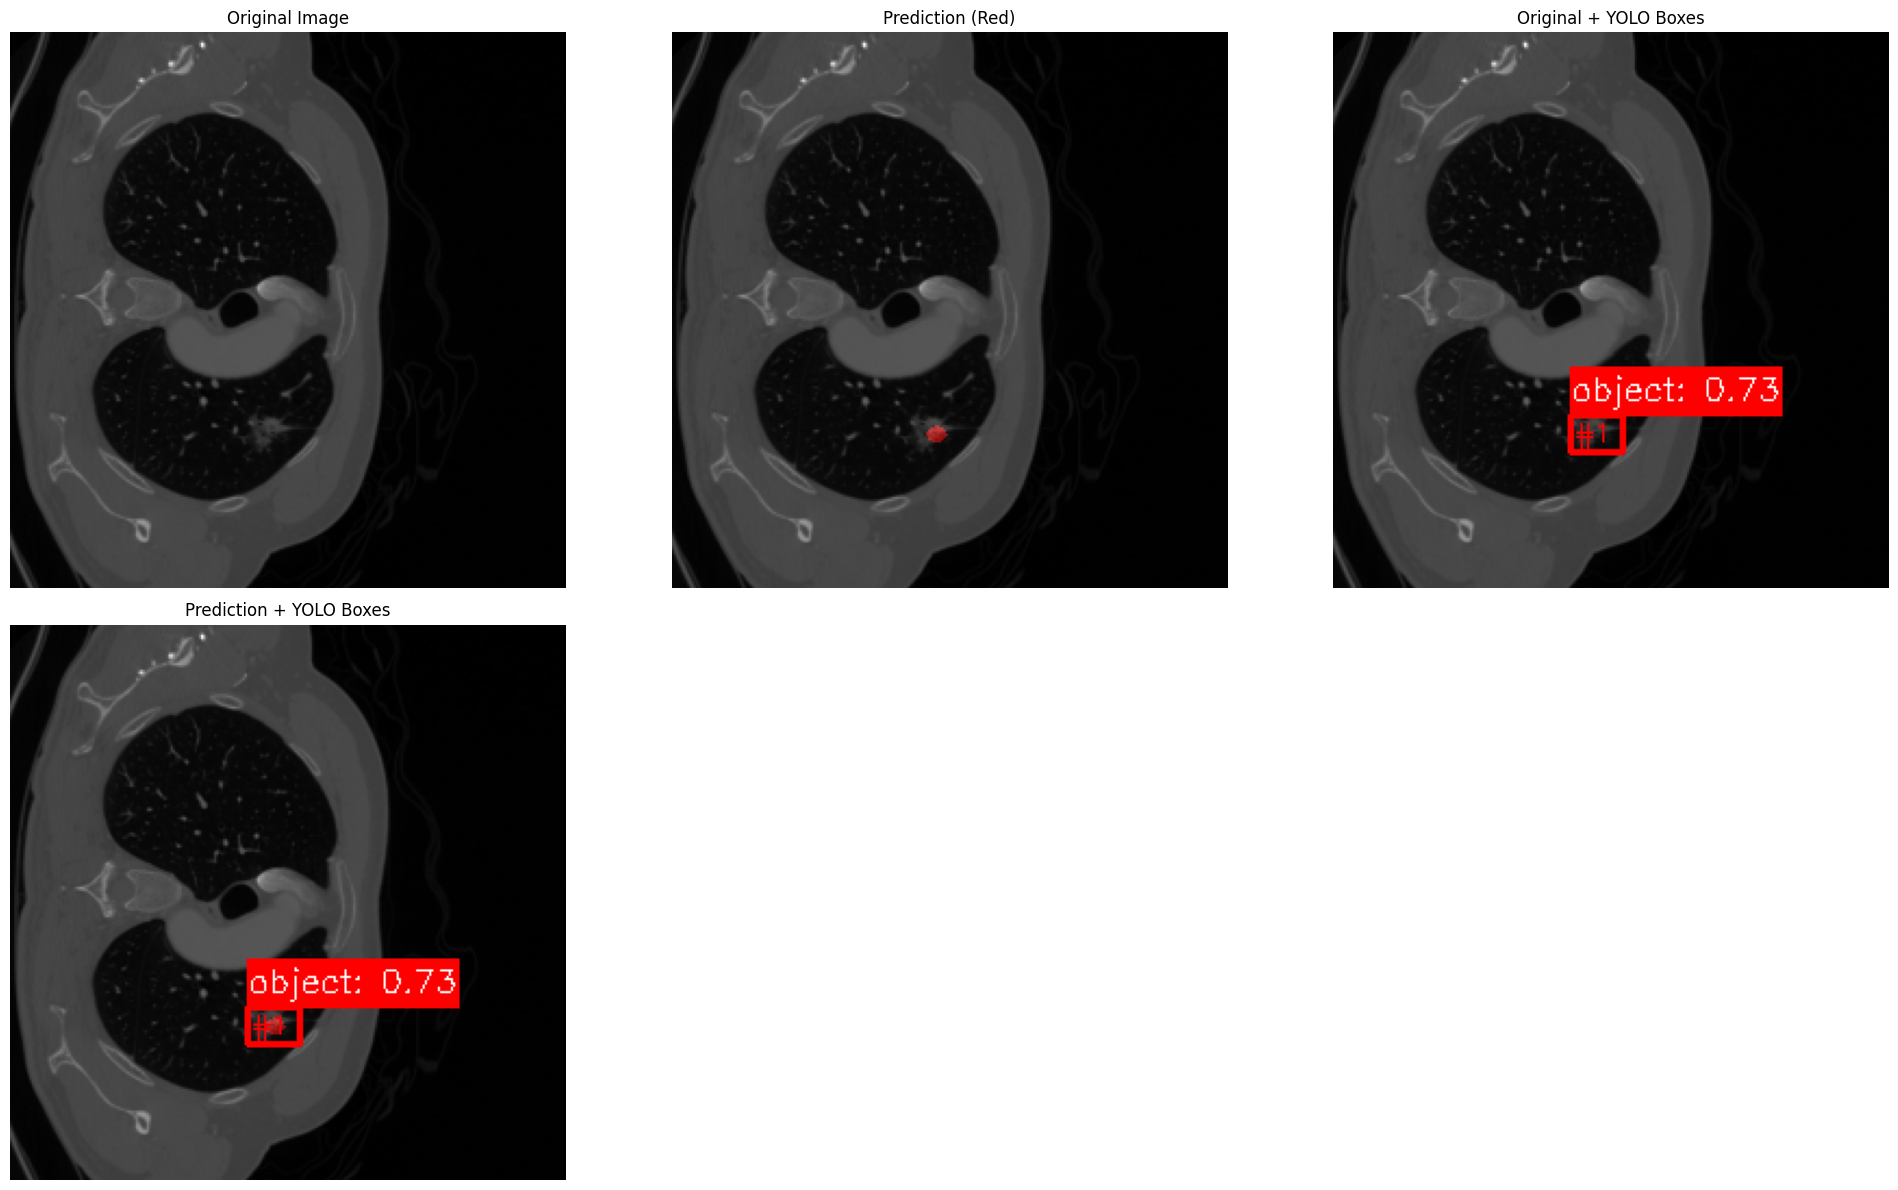

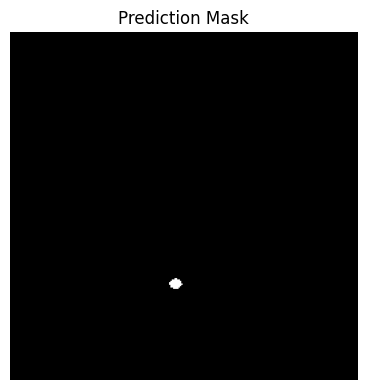

In [36]:
test_img_path = shehapkhalil_cv_data_set_path+"/val/images/Subject_58/280.png"
test_bbox_path = "/kaggle/input/cv-data-set/val/detections/Subject_58/280.txt"
test_mask_image = '/kaggle/input/cv-data-set/val/masks/Subject_58/280.png'
inference_transform = A.Compose([
    A.Resize(height=256, width=256),
    ToTensorV2(),
])
yolo_results = yolo_model(test_img_path)

# Then perform segmentation
results = segment_with_boxes(
    model=model,
    image_path=test_img_path,
    yolo_results=yolo_results,
    device="cuda",
    transform=inference_transform,
    gt_mask_path=test_mask_image,  # optional
    draw_boxes=True  # Enable box drawing
)

visualize_segmentation_results(results,show_boxes=True)
